In [1]:
import pandas as pd

In [2]:
no_missing_merged_loc = pd.read_csv('clean_for_training.csv')

In [3]:
no_missing_merged_loc.drop(columns='Unnamed: 0', inplace=True)

In [4]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
import pickle

# Define features (X) and target (y)
X = no_missing_merged_loc.drop(columns=['amount'])  # Replace 'amount' with your target column if different
y = no_missing_merged_loc['amount']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split training data for meta-learner (optional)
X_train_base, X_val_meta, y_train_base, y_val_meta = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Initialize QuantileTransformers
qt_amount = QuantileTransformer(output_distribution='normal', random_state=42)
qt_size = QuantileTransformer(output_distribution='normal', random_state=42)

# Fit transformers on training data
# Fit qt_size on transaction and property sizes
qt_size.fit(X_train[['transaction_size_sqm', 'property_size_sqm']])

# Fit qt_amount on the entire `y_train` dataset
qt_amount.fit(y_train.values.reshape(-1, 1))

# Transform sizes in the training, validation, and test sets
X_train_base[['transaction_size_sqm', 'property_size_sqm']] = qt_size.transform(
    X_train_base[['transaction_size_sqm', 'property_size_sqm']]
)
X_val_meta[['transaction_size_sqm', 'property_size_sqm']] = qt_size.transform(
    X_val_meta[['transaction_size_sqm', 'property_size_sqm']]
)
X_test[['transaction_size_sqm', 'property_size_sqm']] = qt_size.transform(
    X_test[['transaction_size_sqm', 'property_size_sqm']]
)

# Transform target variable in the training, validation, and test sets
y_train_base = qt_amount.transform(y_train_base.values.reshape(-1, 1)).flatten()
y_val_meta = qt_amount.transform(y_val_meta.values.reshape(-1, 1)).flatten()
y_test = qt_amount.transform(y_test.values.reshape(-1, 1)).flatten()

# Save the transformers for later use
with open("qt_amount.pkl", "wb") as f:
    pickle.dump(qt_amount, f)
with open("qt_size.pkl", "wb") as f:
    pickle.dump(qt_size, f)

# Print dataset sizes
print(f"Training set (Base models): {X_train_base.shape}")
print(f"Validation set (Meta-learner): {X_val_meta.shape}")
print(f"Test set: {X_test.shape}")




Training set (Base models): (97683, 51)
Validation set (Meta-learner): (32561, 51)
Test set: (32562, 51)


In [5]:
y_train_base.mean()

np.float64(-0.003921848786844588)

Transformed y_train_base (mean, std): -0.003921848786844588 1.0034234296799391
Transformed transaction_size_sqm (mean, std): 0.007203983450588102 0.9941383070619169
Transformed property_size_sqm (mean, std): 0.008337192434127833 0.9942399468406207


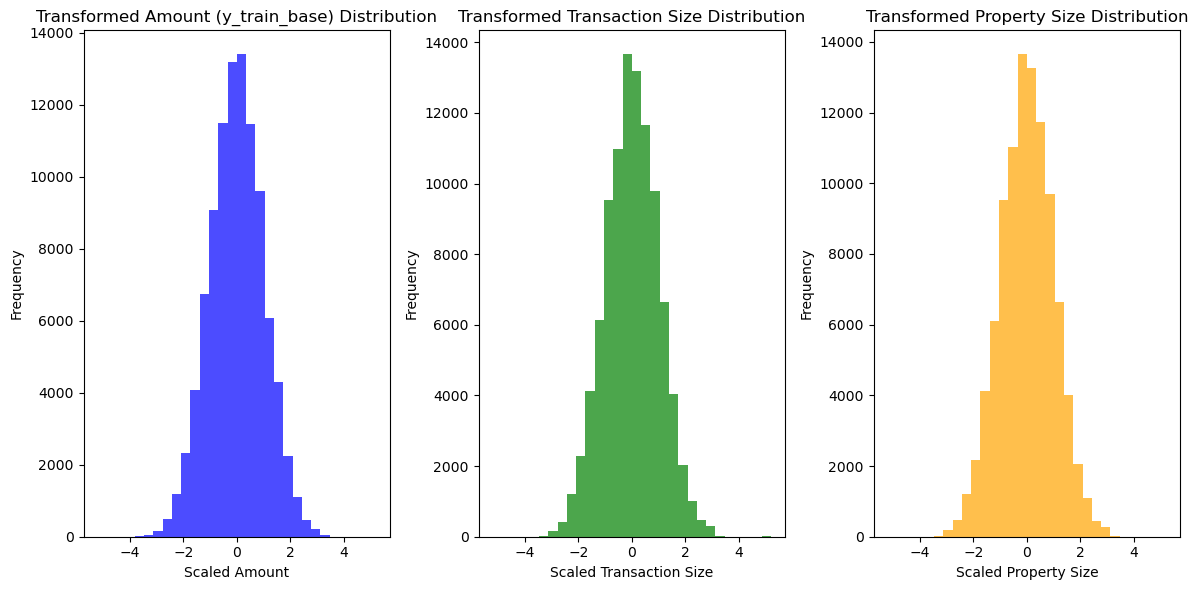

In [6]:
import numpy as np

# Check the transformed training data
print("Transformed y_train_base (mean, std):", np.mean(y_train_base), np.std(y_train_base))
print("Transformed transaction_size_sqm (mean, std):",
      np.mean(X_train_base['transaction_size_sqm']), np.std(X_train_base['transaction_size_sqm']))
print("Transformed property_size_sqm (mean, std):",
      np.mean(X_train_base['property_size_sqm']), np.std(X_train_base['property_size_sqm']))

# Verify that the transformed data is approximately normal
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(y_train_base, bins=30, color='blue', alpha=0.7)
plt.title("Transformed Amount (y_train_base) Distribution")
plt.xlabel("Scaled Amount")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(X_train_base['transaction_size_sqm'], bins=30, color='green', alpha=0.7)
plt.title("Transformed Transaction Size Distribution")
plt.xlabel("Scaled Transaction Size")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(X_train_base['property_size_sqm'], bins=30, color='orange', alpha=0.7)
plt.title("Transformed Property Size Distribution")
plt.xlabel("Scaled Property Size")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [8]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np


# Define XGBoost optimization
def optimize_xgboost(trial, X_train, y_train):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "random_state": 42,
        "early_stopping_rounds": 10,  # Early stopping
        "eval_metric": "rmse"         # Evaluation metric
    }

    model = XGBRegressor(**params)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, test_idx in kf.split(X_train):
        X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

        model.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_test_fold, y_test_fold)],
            verbose=False
        )
        preds = model.predict(X_test_fold)
        cv_scores.append(mean_squared_error(y_test_fold, preds, squared=False))

    return -np.mean(cv_scores)  # Negative for Optuna's maximization

# Define optimization function
def optimize_model(optimize_func, X_train, y_train, n_trials=50):
    def objective(trial):
        return optimize_func(trial, X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print(f"Best trial value: {study.best_value}")
    print(f"Best trial parameters: {study.best_params}")

    return study.best_params

# Prepare the data
# Convert pandas DataFrame/Series to NumPy arrays
X_train_base_np = X_train_base.to_numpy() if hasattr(X_train_base, "to_numpy") else X_train_base
y_train_base_np = y_train_base.to_numpy() if hasattr(y_train_base, "to_numpy") else y_train_base

# Optimize XGBoost
best_params_xgb = optimize_model(optimize_xgboost, X_train_base_np, y_train_base_np)
print("Best parameters for XGBoost:", best_params_xgb)



/home/alkhaldieid/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-27 00:44:54,075] A new study created in memory with name: no-name-88247be4-cbf1-4218-8d14-664850d28725
/home/alkhaldieid/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/alkhaldieid/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/alkhald

Best trial value: -0.28629822102569236
Best trial parameters: {'n_estimators': 412, 'max_depth': 10, 'learning_rate': 0.060542818415401996, 'subsample': 0.8274792836791555}
Best parameters for XGBoost: {'n_estimators': 412, 'max_depth': 10, 'learning_rate': 0.060542818415401996, 'subsample': 0.8274792836791555}


In [9]:
from cuml.ensemble import RandomForestRegressor as cuRFRegressor
from sklearn.model_selection import KFold as cuKFold
from sklearn.metrics import mean_squared_error
import cupy as cp
import numpy as np
import optuna


import warnings

warnings.filterwarnings("ignore", category=UserWarning)
# Prepare the data
# Convert pandas DataFrame/Series to NumPy arrays
X_train_base_np = X_train_base.to_numpy() if hasattr(X_train_base, "to_numpy") else X_train_base
y_train_base_np = y_train_base.to_numpy() if hasattr(y_train_base, "to_numpy") else y_train_base

# Define optimization function
def optimize_model(optimize_func, X_train, y_train, n_trials=50):
    def objective(trial):
        return optimize_func(trial, X_train, y_train)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print(f"Best trial value: {study.best_value}")
    print(f"Best trial parameters: {study.best_params}")

    return study.best_params
# Define GPU-accelerated Random Forest optimization
def optimize_cuml_random_forest(trial, X_train, y_train):
    """
    Optimize cuML Random Forest hyperparameters using Optuna with 5-fold cross-validation.
    """
    # Hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "random_state": 42,  # Ensure reproducibility
    }

    model = cuRFRegressor(**params)

    # Convert data to GPU arrays
    X_train_gpu = cp.array(X_train)
    y_train_gpu = cp.array(y_train)

    # Cross-validation setup
    kf = cuKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, test_idx in kf.split(X_train_gpu):
        X_train_fold, X_test_fold = X_train_gpu[train_idx], X_train_gpu[test_idx]
        y_train_fold, y_test_fold = y_train_gpu[train_idx], y_train_gpu[test_idx]

        model.fit(X_train_fold, y_train_fold)
        preds = model.predict(X_test_fold)

        # Calculate RMSE and convert predictions back to CPU
        rmse = mean_squared_error(cp.asnumpy(y_test_fold), cp.asnumpy(preds), squared=False)
        cv_scores.append(rmse)

    # Return negative RMSE (Optuna maximizes by default)
    return -np.mean(cv_scores)

# Optimize cuML Random Forest
best_params_cuml_rf = optimize_model(optimize_cuml_random_forest, X_train_base_np, y_train_base_np, n_trials=50)  # Increased trials
print("Best parameters for cuML Random Forest:", best_params_cuml_rf)


[I 2024-11-29 06:35:11,569] A new study created in memory with name: no-name-74ca4d04-a362-4ff8-9101-4b7ea65d4bb3
/home/alkhaldieid/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/alkhaldieid/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/alkhaldieid/miniforge3/envs/rapids-24.10/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed 

Best trial value: -0.30176179711220275
Best trial parameters: {'n_estimators': 213, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}
Best parameters for cuML Random Forest: {'n_estimators': 213, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}


In [11]:
best_params_cuml_rf

{'n_estimators': 213,
 'max_depth': 19,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'bootstrap': False}

In [ ]:
xgb_model = XGBRegressor(**best_params_xgb, random_state=42)

# Train the model on the full training data
xgb_model.fit(X_train_base_np, y_train_base_np)

# Evaluate the model on the test data
y_pred = xgb_model.predict(X_test_base_np)
rmse = mean_squared_error(y_test_base_np, y_pred, squared=False)

print(f"RMSE on test data: {rmse}")

In [ ]:
from cuml.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialize the Random Forest model with the best parameters
rf_model = RandomForestRegressor(**best_params_rf, random_state=42)

# Train the model on the full training data
rf_model.fit(X_train_base_np, y_train_base_np)

# Evaluate the model on the test data
y_pred_rf = rf_model.predict(X_test_base_np)

# Calculate RMSE
rmse_rf = mean_squared_error(y_test_base_np, y_pred_rf, squared=False)

print(f"RMSE on test data for Random Forest: {rmse_rf}")


Best parameters for GPU-Accelerated SVR: 

{'C': 84.76283883453274, 'epsilon': 0.13537940431984122, 'kernel': 'rbf'}

In [12]:
print('d')

d
